In [55]:
from eva_cttv_pipeline.clinvar_xml_utils import *
from consequence_prediction.repeat_expansion_variants.clinvar_identifier_parsing import parse_variant_identifier

import os
from urllib import request
import xml.etree.ElementTree as ElementTree
from collections import Counter

import hgvs.parser
from hgvs.exceptions import HGVSParseError

import numpy as np
import pandas as pd

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

In [58]:
parser = hgvs.parser.Parser()

In [59]:
PROJECT_ROOT = '/home/april/projects/opentargets'

# dump of all records with no functional consequences: June consequence pred + ClinVar 6/26/2021
no_consequences_path = os.path.join(PROJECT_ROOT, 'no-consequences.xml.gz')

In [60]:
dataset = ClinVarDataset(no_consequences_path)

## Gather counts

Among records with no functional consequences
* how many of each variant type
* how many have hgvs, sequence location w/ start/stop position at least, cytogenic location
* of those with hgvs, how many can the library parse?
    * how many can our code parse?

In [ ]:
variant_type_hist = Counter()
total_count = 0

spdi_count = 0
hgvs_count = 0
toplevel_refseq_hgvs_count = 0
cytogenetic_count = 0
start_stop_count = 0
strict_parseable_hgvs_count = 0
our_parseable_hgvs_count = 0

for record in dataset:
    if record.measure:
        m = record.measure
        if m.has_complete_coordinates:
            continue
            
        total_count += 1
        variant_type_hist[m.variant_type] += 1
            
        # hgvs count
        if m.hgvs:
            hgvs_count += 1
            if m.toplevel_refseq_hgvs:
                toplevel_refseq_hgvs_count += 1

            # parseability
            one_strict_parseable = False
            one_our_parseable = False
            for hgvs in m.hgvs:
                try:
                    parser.parse_hgvs_variant(hgvs)
                    one_strict_parseable = True
                except:
                    pass
                try:
                    if any(parse_variant_identifier(hgvs)):
                        one_our_parseable = True
                except:
                    pass
            if one_strict_parseable:
                strict_parseable_hgvs_count += 1
            if one_our_parseable:
                our_parseable_hgvs_count += 1
                
            
        measure_xml = m.measure_xml
        if find_elements(measure_xml, './CytogeneticLocation'):
            cytogenetic_count += 1
        if find_elements(measure_xml, './CanonicalSPDI'):
            spdi_count += 1
        
        # probably the minimum we need for consequence prediction
        if m.sequence_location_helper('Chr') and m.sequence_location_helper('start') and m.sequence_location_helper('stop'):
            start_stop_count += 1

In [87]:
print(total_count)

17649


<BarContainer object of 15 artists>

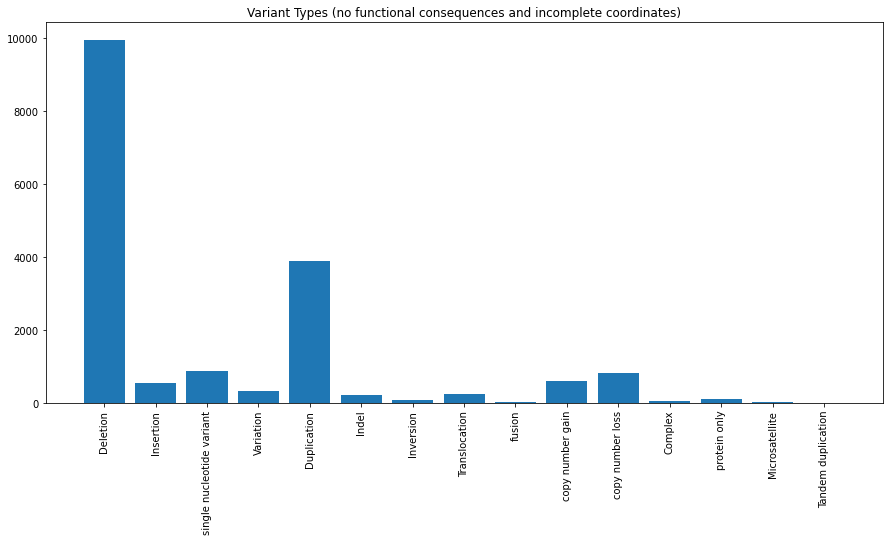

In [94]:
plt.figure(figsize=(15,7))
plt.xticks(rotation='vertical')
plt.title('Variant Types (no functional consequences and incomplete coordinates)')
plt.bar(variant_type_hist.keys(), variant_type_hist.values())

In [64]:
variant_type_hist

Counter({'Deletion': 9937,
         'Insertion': 552,
         'single nucleotide variant': 864,
         'Variation': 311,
         'Duplication': 3875,
         'Indel': 213,
         'Inversion': 73,
         'Translocation': 230,
         'fusion': 10,
         'copy number gain': 596,
         'copy number loss': 813,
         'Complex': 63,
         'protein only': 99,
         'Microsatellite': 12,
         'Tandem duplication': 1})

<BarContainer object of 7 artists>

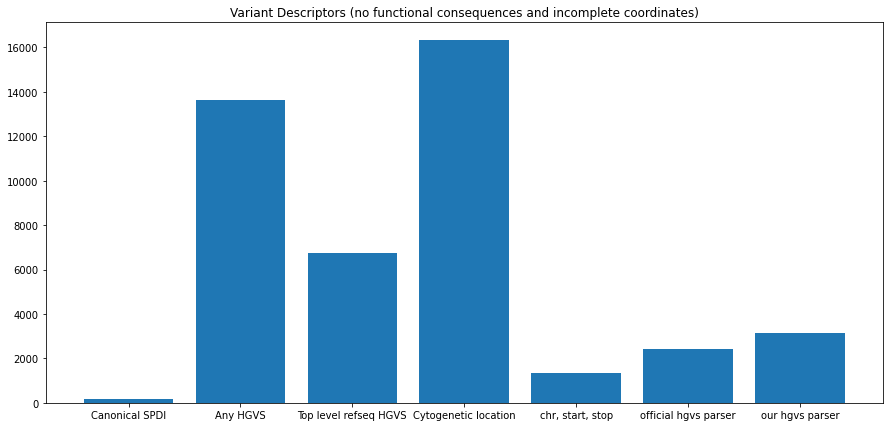

In [91]:
other_counts = {
    'Canonical SPDI': spdi_count,
    'Any HGVS': hgvs_count,
    'Top level refseq HGVS': toplevel_refseq_hgvs_count,
    'Cytogenetic location': cytogenetic_count,
    'chr, start, stop': start_stop_count,
    'official hgvs parser': strict_parseable_hgvs_count,
    'our hgvs parser': our_parseable_hgvs_count
}
plt.figure(figsize=(15,7))
plt.title('Variant Descriptors (no functional consequences and incomplete coordinates)')
plt.bar(other_counts.keys(), other_counts.values())

In [66]:
other_counts

{'Canonical SPDI': 183,
 'Any HGVS': 13619,
 'Top level refseq HGVS': 6730,
 'Cytogenetic location': 16317,
 'chr, start, stop': 1344,
 'official hgvs parser': 2402,
 'our hgvs parser': 3165}

### Examples

Some hand-picked examples of complex variants from ClinVar.  For each type I tried to choose at least one that seemed "typical" and one that was relatively high quality to get an idea of the variability, but no guarantees for how representative these are.

* Duplication
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1062574/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/89496/
* Deletion
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1011851/
* Inversion
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/268016/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/90611/
* Translocation
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/267959/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/267873/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1012364/
* copy number gain
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/523250/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/870516/
* copy number loss
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/1047901/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/625801/
* Complex
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/267835/
    * https://www.ncbi.nlm.nih.gov/clinvar/variation/585332/

In [80]:
def print_link_for_type(variant_type, min_score=-1):
    for record in dataset:
        if record.measure:
            m = record.measure
            if m.has_complete_coordinates:
                continue

            if m.variant_type == variant_type and record.score >= min_score:
                print(f'https://www.ncbi.nlm.nih.gov/clinvar/{record.accession}/')

In [ ]:
print_link_for_type('copy number loss', min_score=1)